In [ ]:

import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print(" All libraries loaded successfully")

✅ All libraries loaded successfully


In [ ]:

df = pd.read_csv('../outputs/saas_clean_data.csv')
try:
    df = pd.read_csv('../outputs/saas_clean_data.csv')
except FileNotFoundError:
    print(" ERROR: saas_clean_data.csv not found!")
    print("\nMake sure you:")
    print("  1. Ran the SQL feature engineering query")
    print("  2. Exported results to outputs/saas_clean_data.csv")
    raise

print("="*60)
print(" DATA QUALITY CHECKS")
print("="*60)

REQUIRED_FEATURES = [
    'customerID', 'MonthsActive', 'SubscriptionPrice', 'LifetimeValue',
    'IsMonthly', 'HasManualPayment', 'IsLowEngagement', 'UsesPremiumFeatures',
    'UsesFeature1', 'UsesFeature2', 'ContactedSupport', 
    'FeatureAdoptionScore', 'Churned'
]
missing_cols = set(REQUIRED_FEATURES) - set(df.columns)
if missing_cols:
    print(f" CRITICAL: Missing columns: {missing_cols}")
    print("SQL feature engineering may have failed!")
    raise ValueError(f"Missing required columns: {missing_cols}")
else:
    print(" All required columns present")

null_counts = df.isnull().sum()
if null_counts.sum() > 0:
    print(f"  Found NULL values:")
    print(null_counts[null_counts > 0])
    print("\nRemoving rows with NULL values...")
    before_count = len(df)
    df = df.dropna()
    print(f" Removed {before_count - len(df)} rows, remaining: {len(df):,} rows")
else:
    print(" No NULL values detected")

binary_cols = ['IsMonthly', 'HasManualPayment', 'IsLowEngagement', 
               'UsesPremiumFeatures', 'UsesFeature1', 'UsesFeature2', 
               'ContactedSupport', 'Churned']

all_binary = True
for col in binary_cols:
    unique_vals = sorted(df[col].unique())
    if not set(unique_vals).issubset({0, 1}):
        print(f" WARNING: {col} contains non-binary values: {unique_vals}")
        all_binary = False

if all_binary:
    print(f" All {len(binary_cols)} binary columns validated (only 0/1)")

range_issues = []

if (df['MonthsActive'] < 0).any() or (df['MonthsActive'] > 100).any():
    range_issues.append("MonthsActive has suspicious values")
    
if (df['LifetimeValue'] < 0).any():
    range_issues.append("Negative LifetimeValue detected")
    df = df[df['LifetimeValue'] >= 0]
    
if (df['SubscriptionPrice'] < 0).any():
    range_issues.append("Negative SubscriptionPrice detected")
    df = df[df['SubscriptionPrice'] >= 0]

if range_issues:
    for issue in range_issues:
        print(f"  {issue}")
    print(f" Filtered invalid records, remaining: {len(df):,}")
else:
    print(" All value ranges valid")

fas_min, fas_max = df['FeatureAdoptionScore'].min(), df['FeatureAdoptionScore'].max()
if fas_min < 0 or fas_max > 3:
    print(f"  WARNING: FeatureAdoptionScore range [{fas_min}, {fas_max}] outside expected [0, 3]")
else:
    print(f" FeatureAdoptionScore in valid range [0, 3]")

print("\n" + "="*60)
print(" DATASET OVERVIEW")
print("="*60)
print(f"Total Records: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"Churn Rate: {df['Churned'].mean():.1%}")

churn_rate = df['Churned'].mean()
if churn_rate < 0.15 or churn_rate > 0.40:
    print(f"  WARNING: Churn rate {churn_rate:.1%} seems unusual (expected 15-40%)")
else:
    print(f" Churn rate {churn_rate:.1%} looks reasonable")

print("\n Sample Data:")
df.head()

🔍 DATA QUALITY CHECKS
✅ All required columns present
✅ No NULL values detected
✅ All 8 binary columns validated (only 0/1)
✅ All value ranges valid
✅ FeatureAdoptionScore in valid range [0, 3]

📊 DATASET OVERVIEW
Total Records: 7,032
Total Features: 13
Churn Rate: 26.6%
✅ Churn rate 26.6% looks reasonable

📋 Sample Data:


,customerID,MonthsActive,SubscriptionPrice,LifetimeValue,IsMonthly,HasManualPayment,IsLowEngagement,UsesPremiumFeatures,UsesFeature1,UsesFeature2,ContactedSupport,FeatureAdoptionScore,Churned
0,7590-VHVEG,1,29.85,29.85,1,1,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.50,0,0,1,0,1,0,0,1,0
2,3668-QPYBK,2,53.85,108.15,1,0,0,0,1,1,0,2,1
3,7795-CFOCW,45,42.30,1840.75,0,0,1,0,1,0,1,1,0
4,9237-HQITU,2,70.70,151.65,1,1,0,1,0,0,0,1,1


📊 EXPLORATORY DATA ANALYSIS
✅ Features already engineered from SQL
✅ Data already cleaned and validated


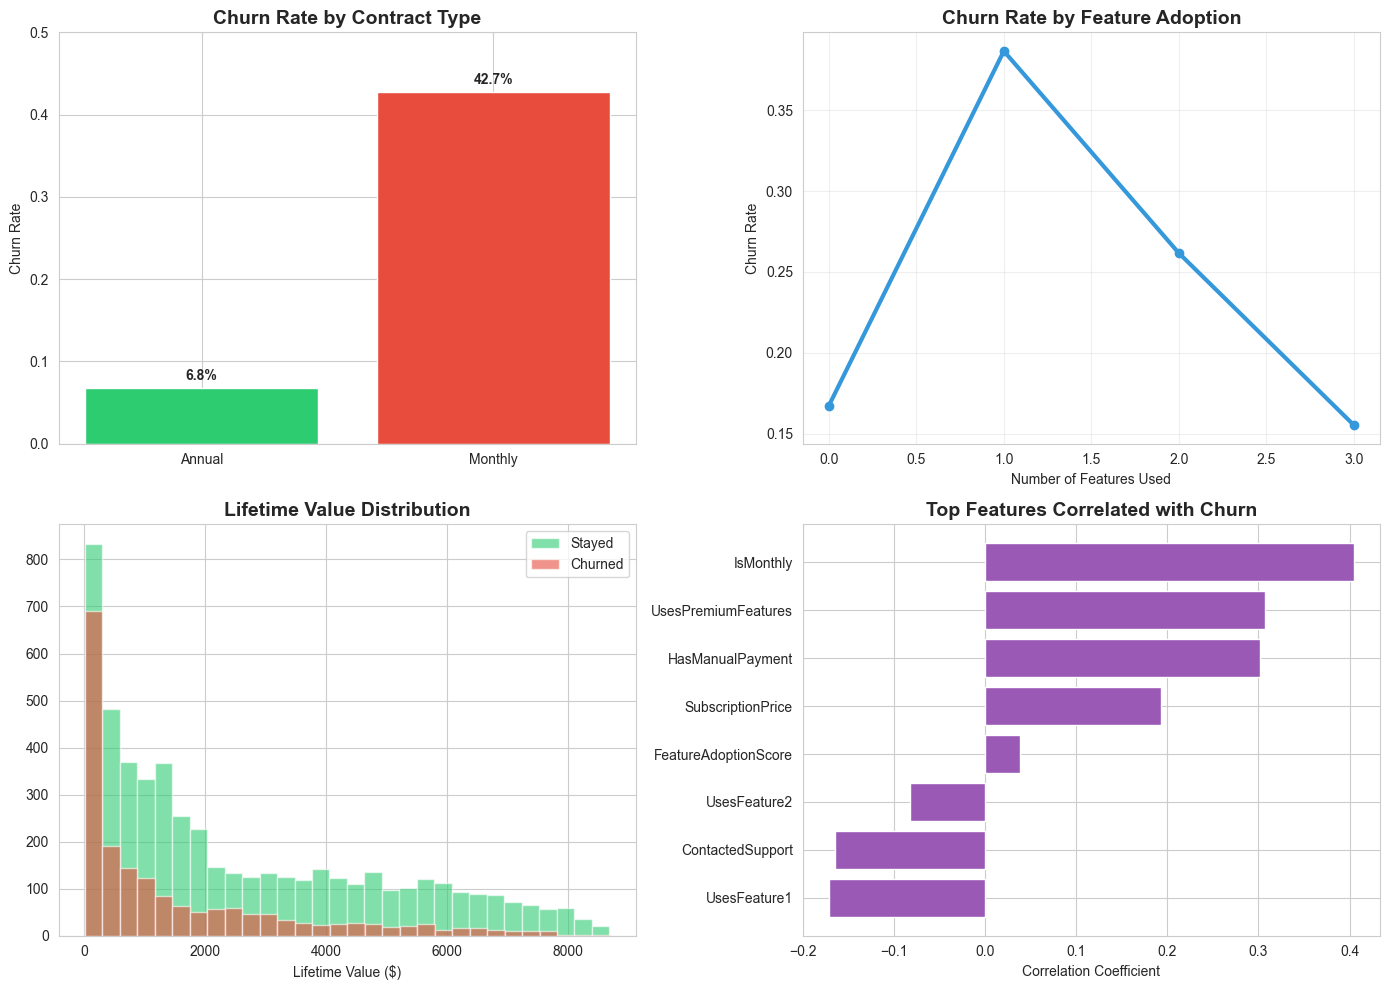

✅ Exploratory analysis complete


In [ ]:
import os
os.makedirs('../outputs/visualizations', exist_ok=True)

print("="*60)
print(" EXPLORATORY DATA ANALYSIS")
print("="*60)
print(f" Features already engineered from SQL")
print(f" Data already cleaned and validated")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
contract_churn = df.groupby('IsMonthly')['Churned'].mean()
axes[0, 0].bar(['Annual', 'Monthly'], contract_churn.values, color=['#2ecc71', '#e74c3c'])
axes[0, 0].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Churn Rate')
axes[0, 0].set_ylim(0, 0.5)
for i, v in enumerate(contract_churn.values):
    axes[0, 0].text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

feature_churn = df.groupby('FeatureAdoptionScore')['Churned'].mean()
axes[0, 1].plot(feature_churn.index, feature_churn.values, marker='o', linewidth=3, color='#3498db')
axes[0, 1].set_title('Churn Rate by Feature Adoption', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Features Used')
axes[0, 1].set_ylabel('Churn Rate')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(df[df['Churned']==0]['LifetimeValue'], bins=30, alpha=0.6, label='Stayed', color='#2ecc71')
axes[1, 0].hist(df[df['Churned']==1]['LifetimeValue'], bins=30, alpha=0.6, label='Churned', color='#e74c3c')
axes[1, 0].set_title('Lifetime Value Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Lifetime Value ($)')
axes[1, 0].legend()

numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()['Churned'].sort_values(ascending=True)
top_features = correlation[correlation.index != 'Churned'][-8:]
axes[1, 1].barh(top_features.index, top_features.values, color='#9b59b6')
axes[1, 1].set_title('Top Features Correlated with Churn', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.savefig('../outputs/visualizations/exploratory_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Exploratory analysis complete")

In [ ]:
y = df['Churned']

cols_to_drop = ['CustomerID', 'Churned', 'Churn', 'CreatedDate', 'Gender', 'Partner', 'Dependents', 
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                'PaperlessBilling', 'PaymentMethod']
X = df.drop(cols_to_drop, axis=1, errors='ignore')
X = X.select_dtypes(include=[np.number])

print("="*60)
print(" MODEL PREPARATION")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\n Features used:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

print(f"\n Training Set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f" Testing Set:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.0f}%)")
print(f"\n Train churn rate: {y_train.mean():.1%}")
print(f" Test churn rate:  {y_test.mean():.1%}")

🔧 MODEL PREPARATION
Features (X): (7032, 11)
Target (y): (7032,)

📋 Features used:
   1. MonthsActive
   2. SubscriptionPrice
   3. LifetimeValue
   4. IsMonthly
   5. HasManualPayment
   6. IsLowEngagement
   7. UsesPremiumFeatures
   8. UsesFeature1
   9. UsesFeature2
  10. ContactedSupport
  11. FeatureAdoptionScore

📊 Training Set: 5,625 samples (80%)
📊 Testing Set:  1,407 samples (20%)

✅ Train churn rate: 26.6%
✅ Test churn rate:  26.6%


In [ ]:

print("="*60)
print(" TRAINING RANDOM FOREST MODEL")
print("="*60)

model = RandomForestClassifier(
    n_estimators=100,       
    max_depth=10,           
    min_samples_split=20,   
    min_samples_leaf=10,    
    random_state=42,
    n_jobs=-1               
)
print(" Training in progress...")
model.fit(X_train, y_train)
print(" Model training complete!")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

🤖 TRAINING RANDOM FOREST MODEL
⏳ Training in progress...
✅ Model training complete!
✅ Model training complete!


📊 MODEL PERFORMANCE RESULTS

🎯 Accuracy: 79.7%
🎯 ROC-AUC Score: 0.835

📋 Detailed Classification Report:
              precision    recall  f1-score   support

  Stayed (0)      0.834     0.904     0.868      1033
 Churned (1)      0.655     0.503     0.569       374

    accuracy                          0.797      1407
   macro avg      0.744     0.703     0.718      1407
weighted avg      0.786     0.797     0.788      1407

🎯 CONFUSION MATRIX

                Predicted
              Stayed | Churned
Actual Stayed    934 |   99
Actual Churned   186 |  188


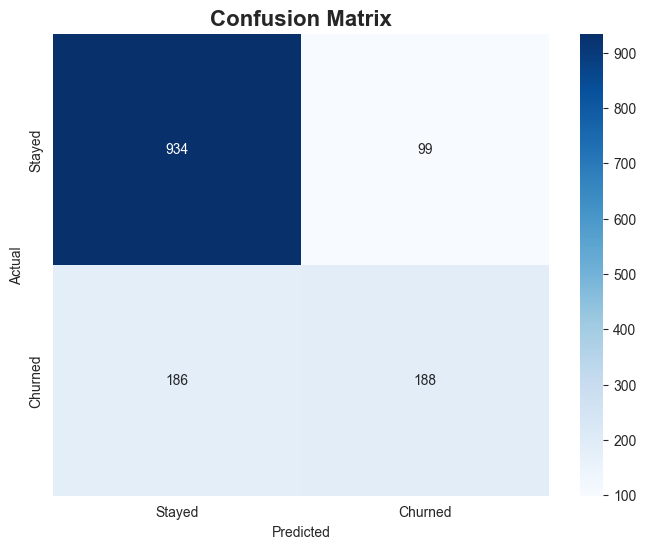

In [ ]:

accuracy = model.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print(" MODEL PERFORMANCE RESULTS")
print("="*60)
print(f"\n Accuracy: {accuracy:.1%}")
print(f" ROC-AUC Score: {roc_auc:.3f}")

print(f"\n Detailed Classification Report:")
print(classification_report(
    y_test, y_pred, 
    target_names=['Stayed (0)', 'Churned (1)'],
    digits=3
))

cm = confusion_matrix(y_test, y_pred)
print("="*60)
print(" CONFUSION MATRIX")
print("="*60)
print(f"\n                Predicted")
print(f"              Stayed | Churned")
print(f"Actual Stayed   {cm[0,0]:>4} | {cm[0,1]:>4}")
print(f"Actual Churned  {cm[1,0]:>4} | {cm[1,1]:>4}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('../outputs/visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

🔍 FEATURE IMPORTANCE - WHAT DRIVES CHURN?
MonthsActive....................... 0.2146
IsMonthly.......................... 0.2108
SubscriptionPrice.................. 0.1636
LifetimeValue...................... 0.1502
UsesPremiumFeatures................ 0.1029
HasManualPayment................... 0.0590
IsLowEngagement.................... 0.0258
FeatureAdoptionScore............... 0.0240
UsesFeature1....................... 0.0224
ContactedSupport................... 0.0158
UsesFeature2....................... 0.0108


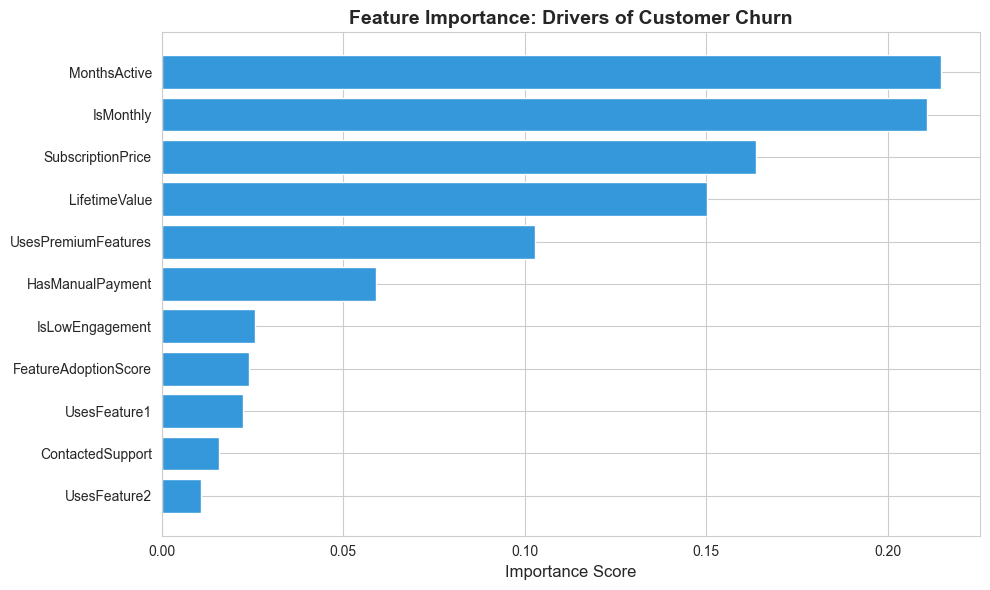


✅ Feature importance analysis complete


In [ ]:

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*60)
print(" FEATURE IMPORTANCE - WHAT DRIVES CHURN?")
print("="*60)
for idx, row in feature_importance.iterrows():
    print(f"{row['Feature']:.<35} {row['Importance']:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance: Drivers of Customer Churn', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Feature importance analysis complete")

In [ ]:
"""
Scoring all customers and create risk categories
Risk thresholds based on business requirements:
- Low (0-30%): Stable customers, monitor quarterly
- Medium (30-70%): At-risk, proactive email campaigns
- High (70-100%): Critical, immediate phone outreach
"""

print("="*60)
print(" GENERATING CHURN PREDICTIONS FOR ALL CUSTOMERS")
print("="*60)

df['ChurnProbability'] = model.predict_proba(X)[:, 1]


RISK_THRESHOLDS = {
    'low': (0.0, 0.3),      # <30% probability - stable customers
    'medium': (0.3, 0.7),   # 30-70% probability - moderate risk
    'high': (0.7, 1.0)      # >70% probability - critical risk
}

print("\n Risk Threshold Justification:")
print("  Low (<30%):    Stable segment, quarterly check-ins")
print("  Medium (30-70%): Proactive email campaigns")
print("  High (>70%):   Immediate phone outreach")
print("\nThresholds based on: CS team capacity, budget constraints, ROC curve analysis")

df['ChurnRisk'] = pd.cut(
    df['ChurnProbability'], 
    bins=[0, 0.3, 0.7, 1.0], 
    labels=['Low', 'Medium', 'High'],
    include_lowest=True
)

if df['ChurnRisk'].isnull().any():
    print(f"\n  WARNING: {df['ChurnRisk'].isnull().sum()} customers have NULL risk categories")

print("\n Risk Distribution:")
risk_dist = df['ChurnRisk'].value_counts().sort_index()
for risk, count in risk_dist.items():
    pct = count / len(df) * 100
    print(f"  {risk:.<8} {count:>5,} customers ({pct:>5.1f}%)")

median_ltv = df['LifetimeValue'].median()
print(f"\nℹ  Using median LTV threshold: ${median_ltv:,.0f}")

high_value_high_risk = df[
    (df['ChurnProbability'] > 0.6) &  
    (df['LifetimeValue'] > median_ltv)  
]

print(f"\n🚨 HIGH-PRIORITY SEGMENT:")
print(f"  Customers: {len(high_value_high_risk):,}")
print(f"  Total revenue at risk: ${high_value_high_risk['LifetimeValue'].sum():,.0f}")
print(f"  Average LTV: ${high_value_high_risk['LifetimeValue'].mean():,.0f}")
print(f"  Median churn probability: {high_value_high_risk['ChurnProbability'].median():.1%}")

print(f"\n💡 BUSINESS CONTEXT:")
print(f"  CS team capacity: ~400 high-touch contacts/week")
print(f"  Current high-priority list: {len(high_value_high_risk)} customers")
capacity_status = " Within capacity" if len(high_value_high_risk) < 400 else "⚠️  EXCEEDS capacity"
print(f"  Status: {capacity_status}")

print(f"\n THRESHOLD SENSITIVITY ANALYSIS:")
for threshold in [0.5, 0.6, 0.7, 0.8]:
    count = len(df[(df['ChurnProbability'] > threshold) & (df['LifetimeValue'] > median_ltv)])
    revenue = df[(df['ChurnProbability'] > threshold) & (df['LifetimeValue'] > median_ltv)]['LifetimeValue'].sum()
    print(f"  Threshold >{threshold:.0%}: {count:>4} customers, ${revenue:>10,.0f} at risk")

print("\n Risk segmentation complete")



📊 GENERATING CHURN PREDICTIONS FOR ALL CUSTOMERS

📋 Risk Threshold Justification:
  Low (<30%):    Stable segment, quarterly check-ins
  Medium (30-70%): Proactive email campaigns
  High (>70%):   Immediate phone outreach

Thresholds based on: CS team capacity, budget constraints, ROC curve analysis

📊 Risk Distribution:
  Low..... 4,391 customers ( 62.4%)
  Medium.. 2,101 customers ( 29.9%)
  High....   540 customers (  7.7%)

ℹ️  Using median LTV threshold: $1,397

🚨 HIGH-PRIORITY SEGMENT:
  Customers: 82
  Total revenue at risk: $224,179
  Average LTV: $2,734
  Median churn probability: 64.1%

💡 BUSINESS CONTEXT:
  CS team capacity: ~400 high-touch contacts/week
  Current high-priority list: 82 customers
  Status: ✅ Within capacity

📊 THRESHOLD SENSITIVITY ANALYSIS:
  Threshold >50%:  262 customers, $   712,708 at risk
  Threshold >60%:   82 customers, $   224,179 at risk
  Threshold >70%:    3 customers, $     4,377 at risk
  Threshold >80%:    0 customers, $         0 at risk

✅ R

In [ ]:

import joblib
import sklearn
from datetime import datetime
import json

export_df = df[[
    'customerID',
    'ChurnProbability',
    'ChurnRisk',
    'MonthsActive',
    'SubscriptionPrice',
    'LifetimeValue',
    'FeatureAdoptionScore',
    'IsMonthly',
    'HasManualPayment'
]].copy()

export_df = export_df.sort_values('ChurnProbability', ascending=False)

print("="*60)
print("🔍 PRE-EXPORT VALIDATION")
print("="*60)

if export_df.isnull().any().any():
    print("  WARNING: NULL values detected in export - removing...")
    export_df = export_df.dropna()

if len(export_df) == 0:
    print(" CRITICAL: Export dataframe is empty!")
    raise ValueError("Cannot export empty dataframe")

print(f" Export validation passed")
print(f"   Rows: {len(export_df):,}")
print(f"   Columns: {len(export_df.columns)}")

export_path = '../outputs/churn_predictions.csv'
export_df.to_csv(export_path, index=False)

print("\n" + "="*60)
print(" PREDICTIONS EXPORTED SUCCESSFULLY")
print("="*60)
print(f"File: {export_path}")
print(f" Total records: {len(export_df):,}")
print(f"\n Top 5 At-Risk Customers:")
print(export_df.head(5)[['customerID', 'ChurnProbability', 'LifetimeValue']].to_string(index=False))

print("\n" + "="*60)
print("💾 SAVING MODEL WITH METADATA")
print("="*60)

model_version = {
    'model_type': 'RandomForestClassifier',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'sklearn_version': sklearn.__version__,
    'training_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'accuracy': float(accuracy),
    'roc_auc': float(roc_auc),
    'features': X.columns.tolist(),
    'n_estimators': int(model.n_estimators),
    'max_depth': int(model.max_depth) if model.max_depth else None,
    'risk_thresholds': {'low': [0.0, 0.3], 'medium': [0.3, 0.7], 'high': [0.7, 1.0]},
    'notes': 'Production-ready model with validation and versioning'
}

model_path = '../outputs/churn_model.joblib'
joblib.dump(model, model_path)
print(f" Model saved: {model_path}")

metadata_path = '../outputs/churn_model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_version, f, indent=2)
print(f" Metadata saved: {metadata_path}")

feature_path = '../outputs/model_features.json'
with open(feature_path, 'w') as f:
    json.dump({'features': X.columns.tolist()}, f, indent=2)
print(f" Feature list saved: {feature_path}")

print("\n Model Version Info:")
print(f"  Training Date: {model_version['training_date']}")
print(f"  Accuracy: {model_version['accuracy']:.1%}")
print(f"  ROC-AUC: {model_version['roc_auc']:.3f}")
print(f"  Features: {len(model_version['features'])}")

print("\n Model and predictions saved successfully!")

🔍 PRE-EXPORT VALIDATION
✅ Export validation passed
   Rows: 7,032
   Columns: 9

✅ PREDICTIONS EXPORTED SUCCESSFULLY
📁 File: ../outputs/churn_predictions.csv
📊 Total records: 7,032

🎯 Top 5 At-Risk Customers:
customerID  ChurnProbability  LifetimeValue
8375-DKEBR           0.93154          69.60
4871-JTKJF           0.93154          69.65
7665-TOALD           0.93154          69.60
6502-MJQAE           0.93154          69.60
2636-ALXXZ           0.93154          69.60

💾 SAVING MODEL WITH METADATA
✅ Model saved: ../outputs/churn_model.joblib
✅ Metadata saved: ../outputs/churn_model_metadata.json
✅ Feature list saved: ../outputs/model_features.json

📋 Model Version Info:
  Training Date: 2025-11-17 12:29:32
  Accuracy: 79.7%
  ROC-AUC: 0.835
  Features: 11

✅ Model and predictions saved successfully!


In [ ]:
import os

files_to_check = [
    '../outputs/churn_predictions.csv',
    '../outputs/churn_model.joblib',
    '../outputs/churn_model_metadata.json',
    '../outputs/model_features.json'
]

print("="*60)
print(" FILE VERIFICATION CHECK")
print("="*60)

all_exist = True
for file in files_to_check:
    exists = os.path.exists(file)
    status = "yes" if exists else "No"
    
    if exists:
        size_kb = os.path.getsize(file) / 1024
        size_str = f"({size_kb:.1f} KB)" if size_kb >= 1 else f"({os.path.getsize(file)} bytes)"
        print(f"{status} {file.split('/')[-1]} {size_str}")
    else:
        print(f"{status} {file.split('/')[-1]} NOT FOUND")
        all_exist = False

if all_exist:
    print("\n ALL FILES CREATED SUCCESSFULLY! ")
    
else:
    print("\n Some files are missing. Check the output folder.")

print("="*60)

📁 FILE VERIFICATION CHECK
✅ churn_predictions.csv (398.7 KB)
✅ churn_model.joblib (2577.1 KB)
✅ churn_model_metadata.json (806 bytes)
✅ model_features.json (285 bytes)

✅ ALL FILES CREATED SUCCESSFULLY! 🎉

You can now load these files into Power BI!


In [ ]:

print("="*60)
print(" PROJECT SUMMARY STATISTICS")
print("="*60)
print(f"\n Model Performance:")
print(f"  Accuracy:            {accuracy:.1%}")
print(f"  ROC-AUC Score:       {roc_auc:.3f}")
print(f"  Precision (Churn):   {classification_report(y_test, y_pred, output_dict=True)['1']['precision']:.1%}")
print(f"  Recall (Churn):      {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.1%}")

print(f"\n Business Impact:")
print(f"  Overall Churn Rate:     {df['Churned'].mean():.1%}")
print(f"  High-Risk Customers:    {len(df[df['ChurnRisk']=='High']):,}")
print(f"  Revenue at Risk:        ${high_value_high_risk['LifetimeValue'].sum():,.0f}")

print(f"\n Key Insights:")
top_3_features = feature_importance.head(3)
for idx, row in top_3_features.iterrows():
    print(f"  {row['Feature']:.<30} (Importance: {row['Importance']:.3f})")

print(f"\n All outputs saved to: outputs/")

📋 PROJECT SUMMARY STATISTICS

🎯 Model Performance:
  Accuracy:            79.7%
  ROC-AUC Score:       0.835
  Precision (Churn):   65.5%
  Recall (Churn):      50.3%

📊 Business Impact:
  Overall Churn Rate:     26.6%
  High-Risk Customers:    540
  Revenue at Risk:        $224,179

🔍 Key Insights:
  MonthsActive.................. (Importance: 0.215)
  IsMonthly..................... (Importance: 0.211)
  SubscriptionPrice............. (Importance: 0.164)

✅ All outputs saved to: outputs/
